In [1]:
# load required libraries
options(stringsAsFactors = F)
options (repr.plot.width = 12, repr.plot.height = 5)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Hmisc)
library(ggsci)
library(viridis)
library(RColorBrewer)
library(ggrepel)
library(cowplot)
})
set.seed(123)

In [2]:
# load samples
sample_exp_220406 <- readRDS("../../1_CAD_Preprocessing/EXP220406/rds/CAD1_clean_clustered.rds")
sample_exp_220406$source <- "CAD1"
sample_exp_220406

sample_exp_230206 <- readRDS("../../1_CAD_Preprocessing/EXP230206/rds/CAD2_clean_clustered.rds")
sample_exp_230206$source <- "CAD2"
sample_exp_230206

sample_exp_220304 <- readRDS("../../1_CAD_Preprocessing/EXP220304/rds/CAD3_clean_clustered.rds")
sample_exp_220304$source <- "CAD3"
sample_exp_220304

An object of class Seurat 
33538 features across 7198 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

An object of class Seurat 
33538 features across 7295 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

An object of class Seurat 
33538 features across 8622 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

In [3]:
# merge sample and normalize
scList <- list(sample_exp_220304, sample_exp_220406, sample_exp_230206)
sample <- merge(scList[[1]], scList[2:3])
sample <- subset(sample, nFeature_RNA >= 500 & nFeature_RNA <= 5000 & percent.mt <= 10)
sample <- NormalizeData(sample, normalization.method = "LogNormalize", scale.factor = 10000)

# find variable Genes and scale data
sample <- FindVariableFeatures(sample, selection.method = "vst")
sample <- ScaleData(sample)
sample

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Centering and scaling data matrix



An object of class Seurat 
33538 features across 20978 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


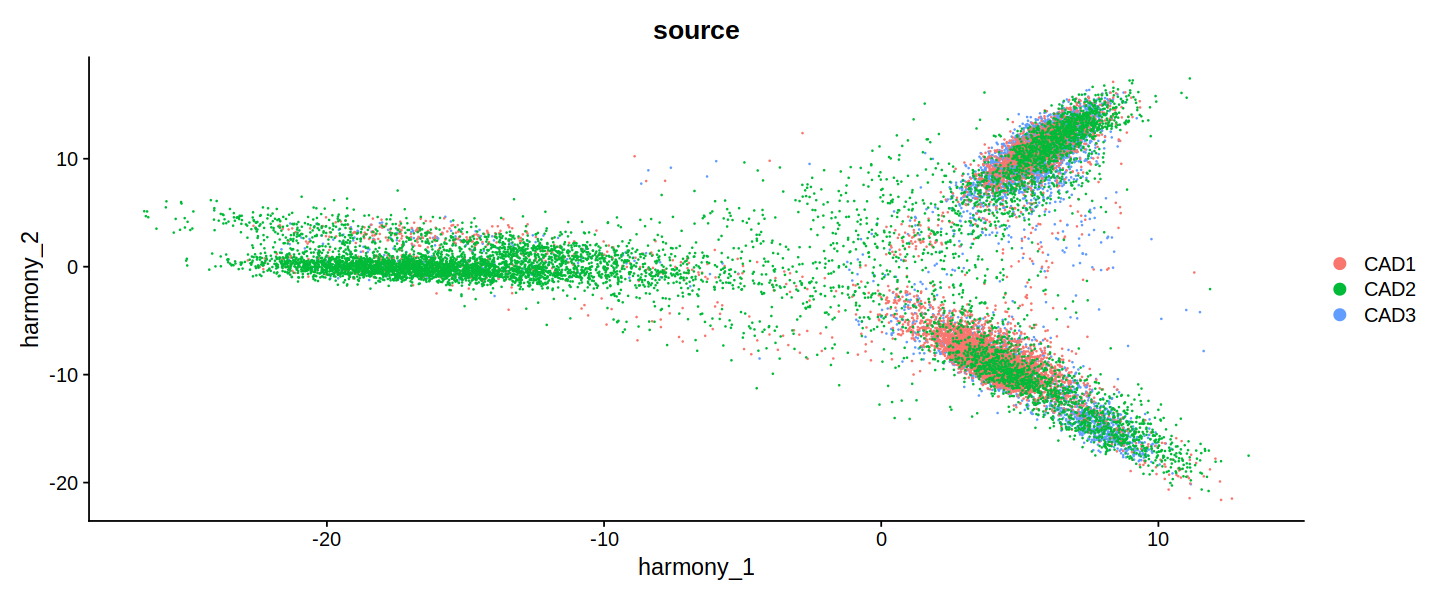

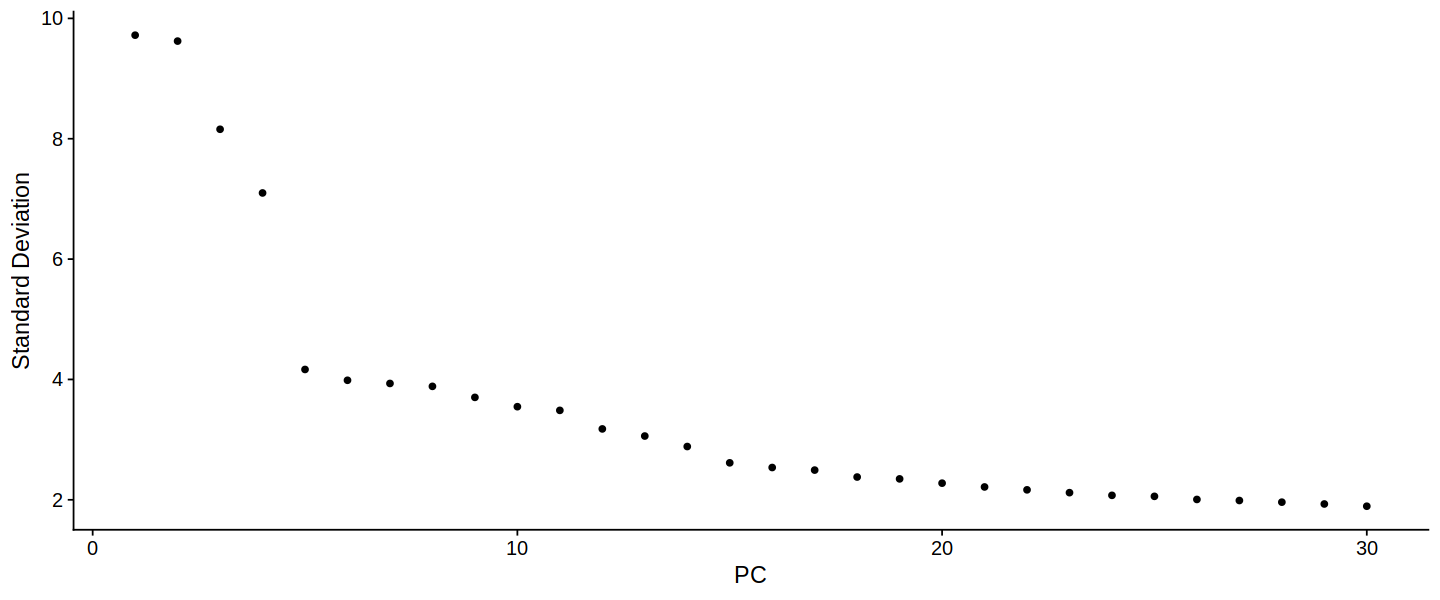

In [4]:
# run pca and harmony
sample <- RunPCA(sample, verbose = FALSE)
sample <- RunHarmony(sample, group.by.vars = "source", verbose = FALSE)
DimPlot(sample, reduction = "harmony", pt.size = 0.1, group.by = "source")
ElbowPlot(sample, ndims = 30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


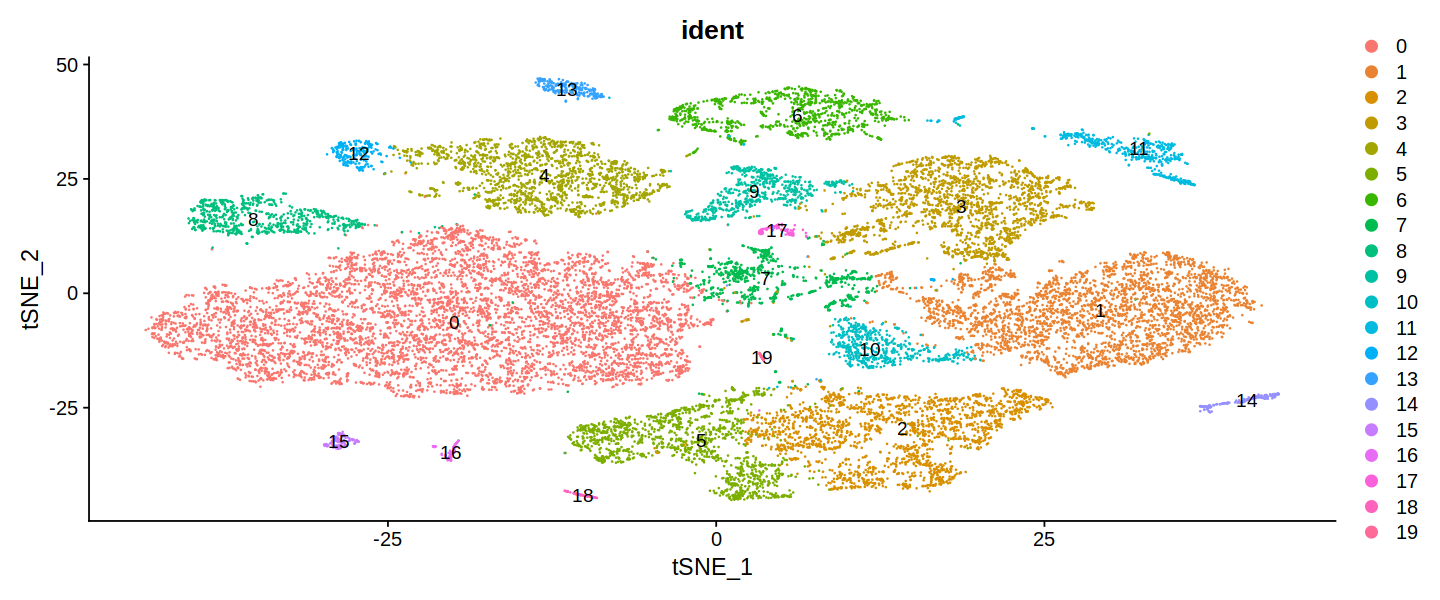

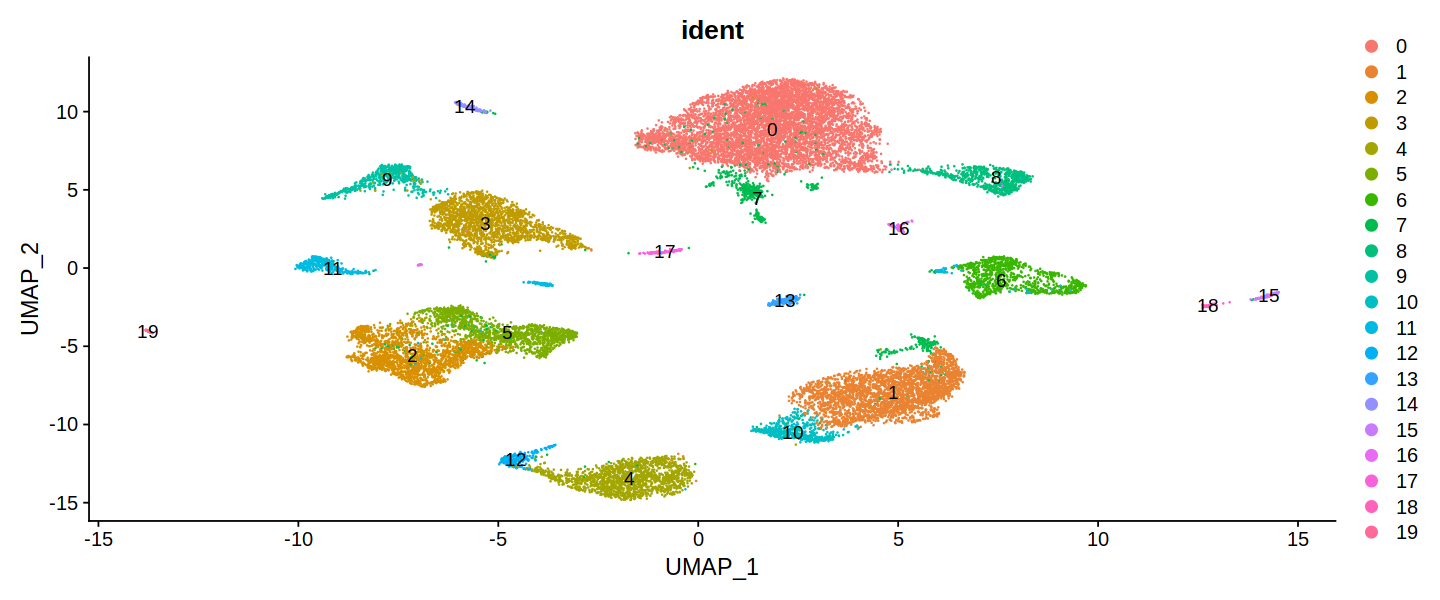

In [5]:
# dimension reduction and clustering
pca_dims <- 1:30
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
DimPlot(sample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

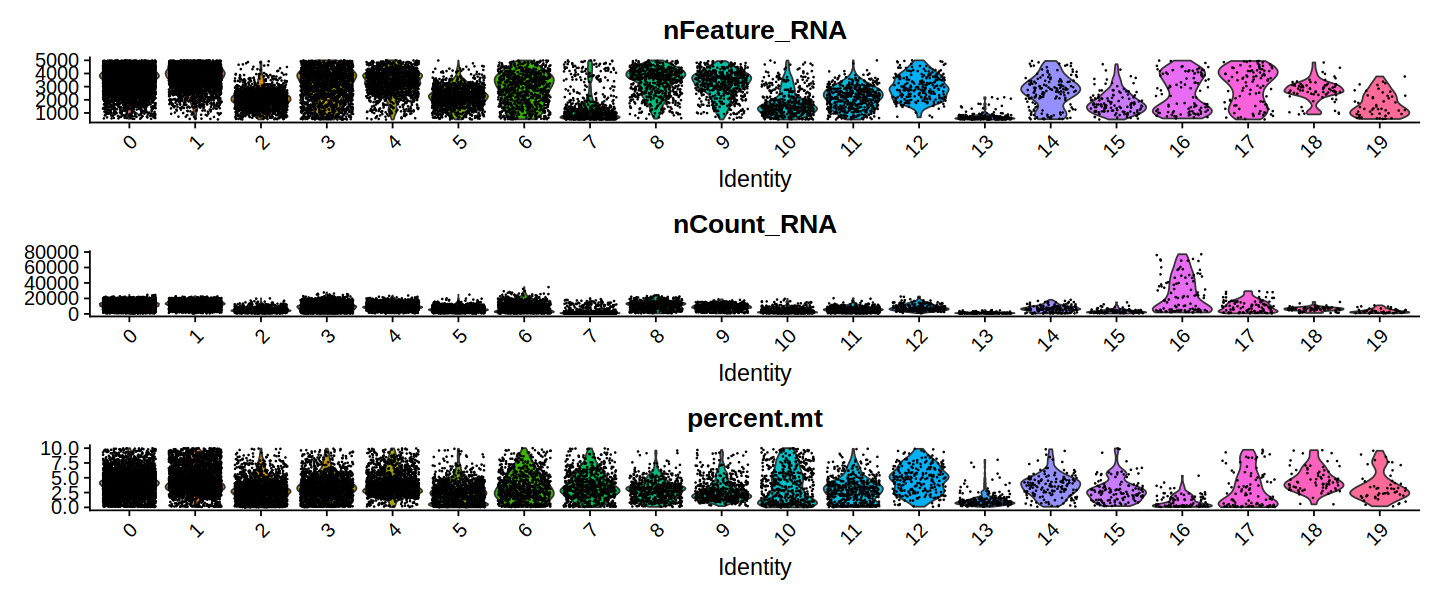

In [6]:
# quality control by cluster
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 1, pt.size = 0.1)
ggsave("figure/qc_sample_by_cluster_CAD.pdf", width = 12, height = 10)

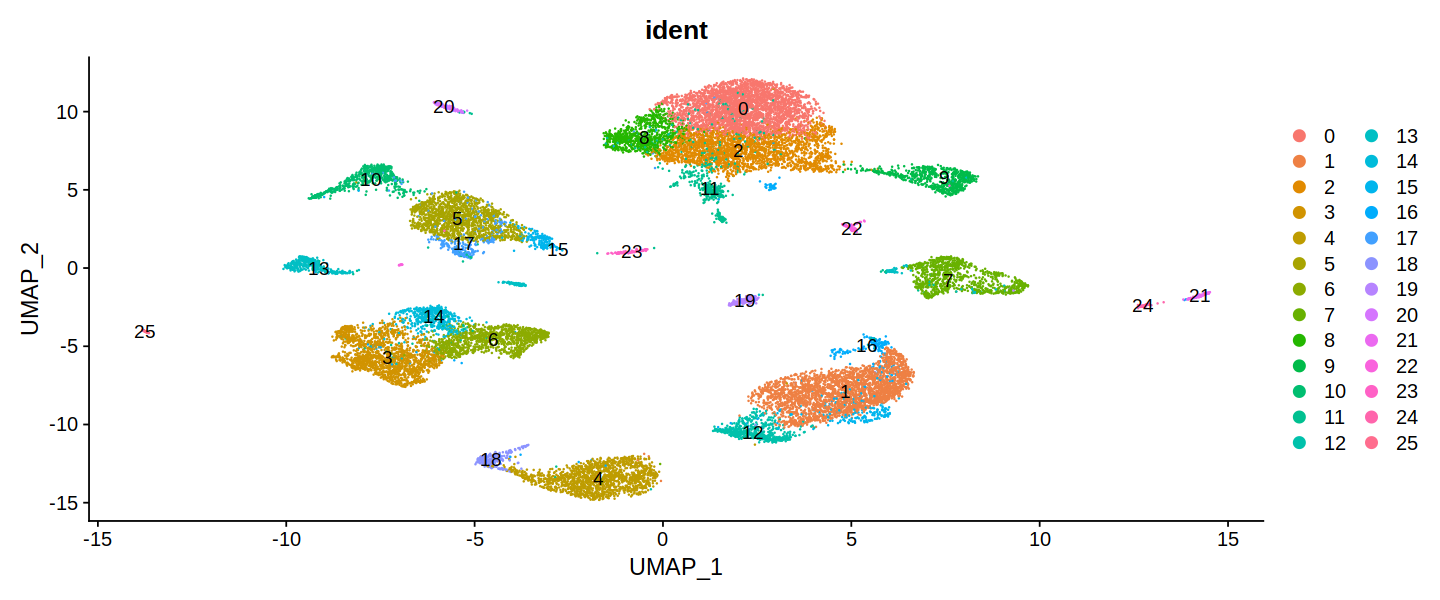

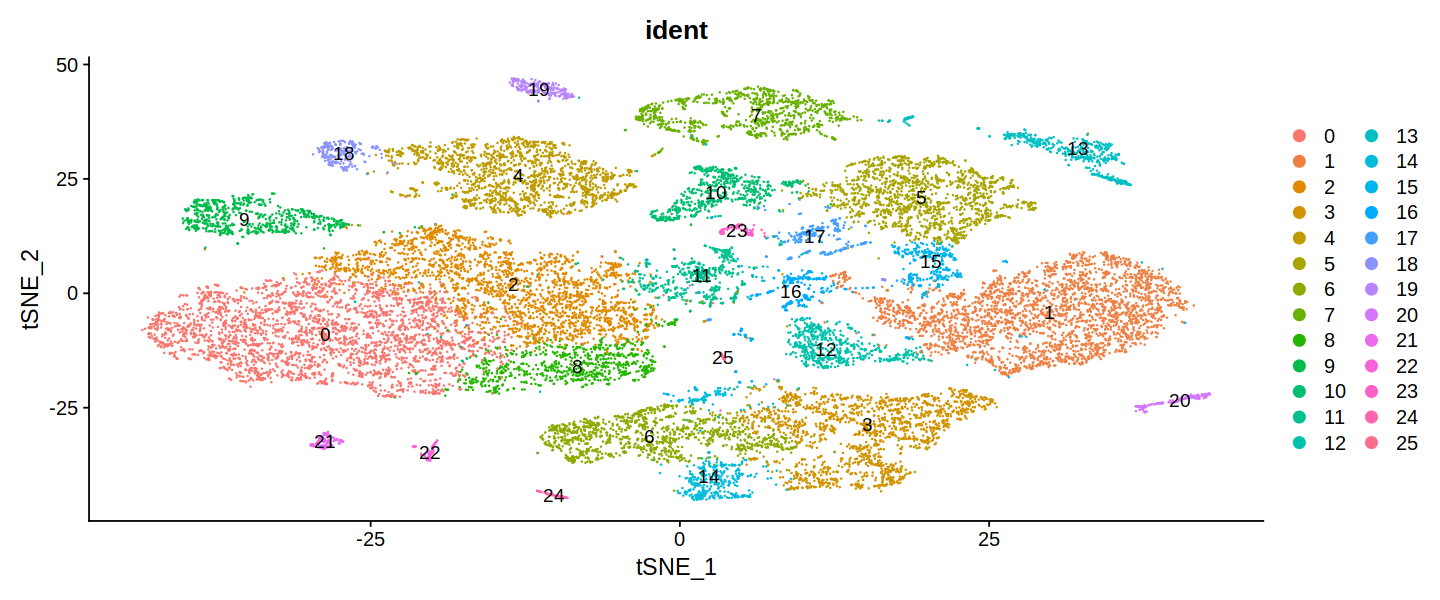

In [7]:
# add resolution
sample <- FindClusters(sample, resolution = 1, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident")
DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident")

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: HPGD5, TPASB1”


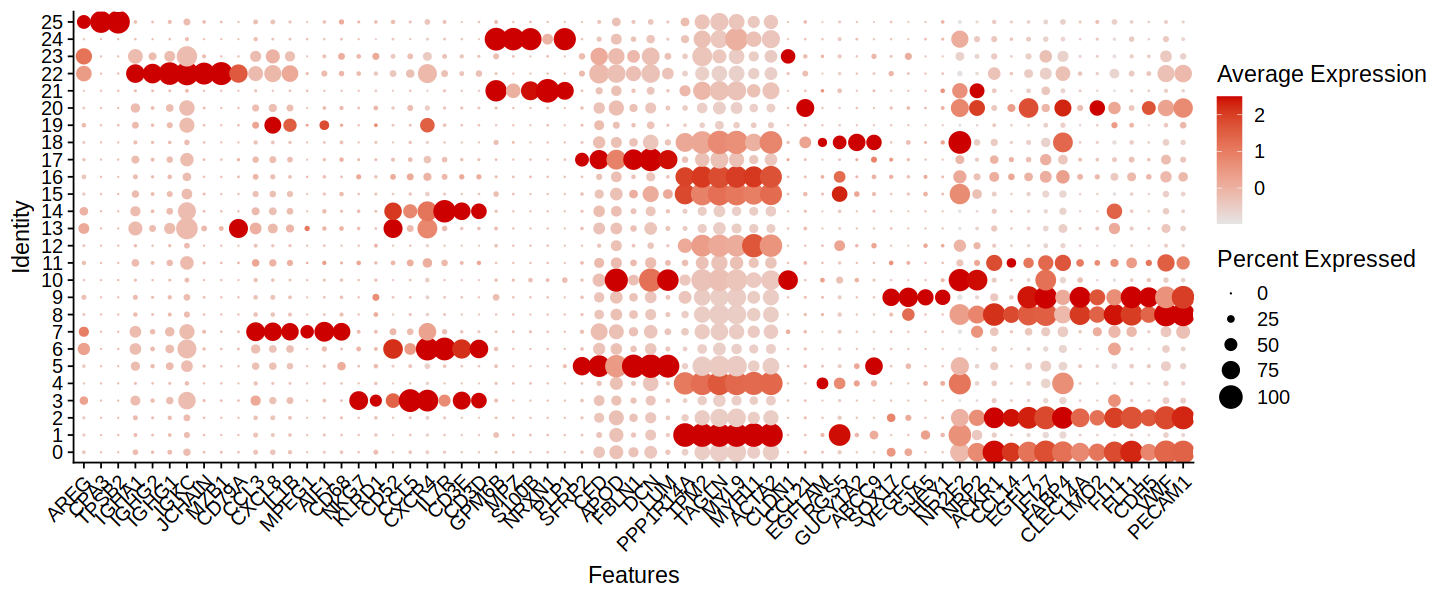

In [8]:
# plot marker genes list
markers <- unique(c("PECAM1","VWF","CDH5","FLT1","FLI1","LMO2","CLEC14A","FABP4","IFI27","EGFL7", # EC
"CCL14","ACKR1","NRP2","NR2F2", # VEC
"HEY1","GJA5","VEGFC","SOX17", # AEC
"ABCC9", "GUCY1A2", "RGS5", "EGFLAM", # Pericyte
"CCL21", # LEC
"CLDN1", # Mesothelial
"ACTA2","MYH11","MYL9","TAGLN","TPM2","RGS5","PPP1R14A", # SMC
"ACTA2","MYH11","LUM","DCN","PPP1R14A", # MyoFB
"LUM","DCN","FBLN1","APOD","CFD","SFRP2", # FB
"PLP1","NRXN1","S100B","MPZ","GPM6B", # OLG
"CD3D","CD3E","IL7R","CXCR4","CCL5","CD52", # T
"KLRD1","NKG7","CCL5", # NK
"CD68","AIF1","MPEG1","IL1B","CXCL8","CCL3","CXCR4", # Macrophage
"CD79A","MZB1","JCHAIN","IGKC","IGHG1","IGHG2","IGHA1", # B
"TPASB1","TPSB2","CPA3","AREG","HPGD5")) # Mast
DotPlot(sample, features=rev(markers), cols=c("grey90","red3"), group.by="seurat_clusters") + theme(axis.text.x=element_text(angle=45, hjust=1))
ggsave("figure/dotplot_CAD_markers_CAD.pdf", width = 18, height = 12)

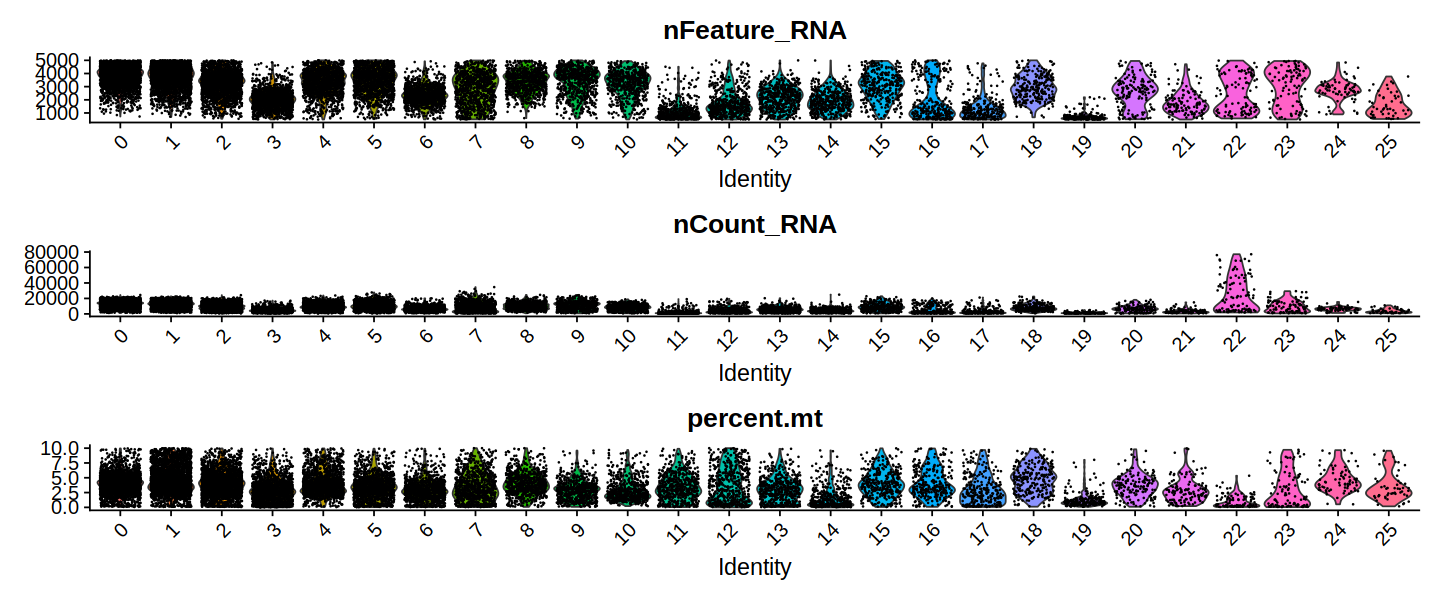

In [9]:
# quality control by cluster
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 1, pt.size = 0.1)
ggsave("figure/qc_sample_by_cluster_res1.pdf", width = 15, height = 10)

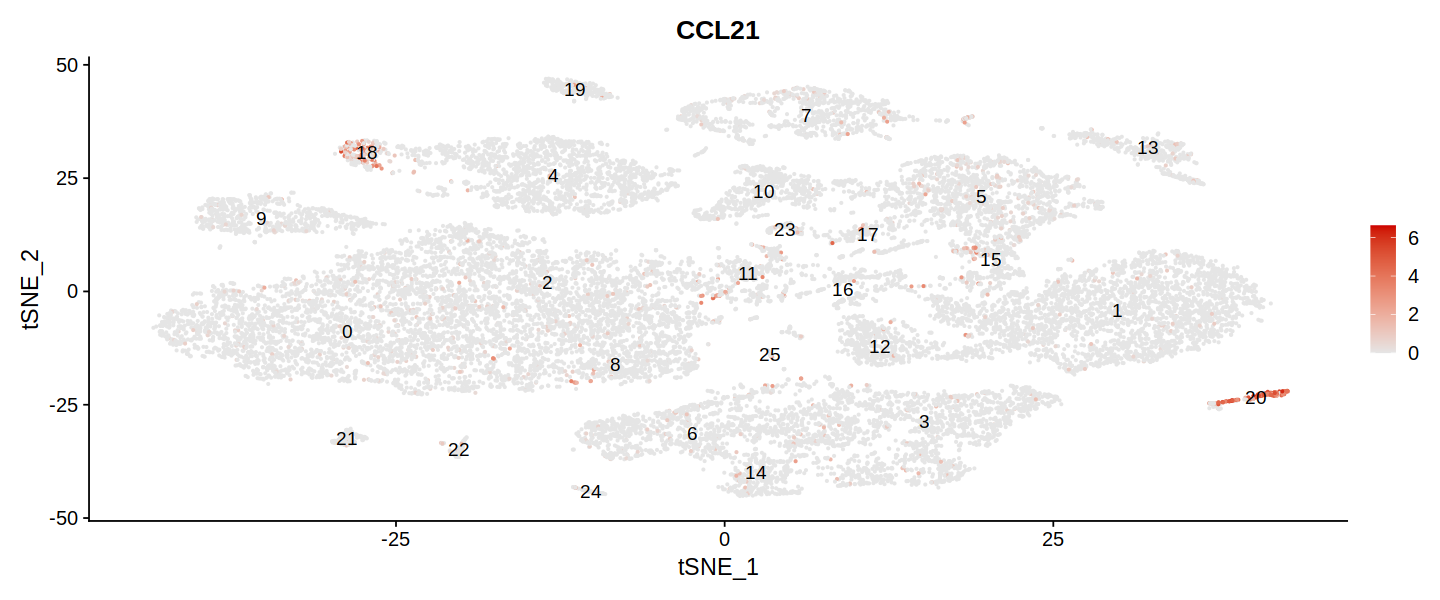

In [10]:
# explore marker genes
FeaturePlot(sample, label = T, features=c("CCL21"), cols=c("grey90","red3"), reduction="tsne", pt.size = 0.5)

In [11]:
# save the sample
saveRDS(sample, file = "rds/sample_CAD.rds")

[1] 33538 18304

[1] 2000

Centering and scaling data matrix

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


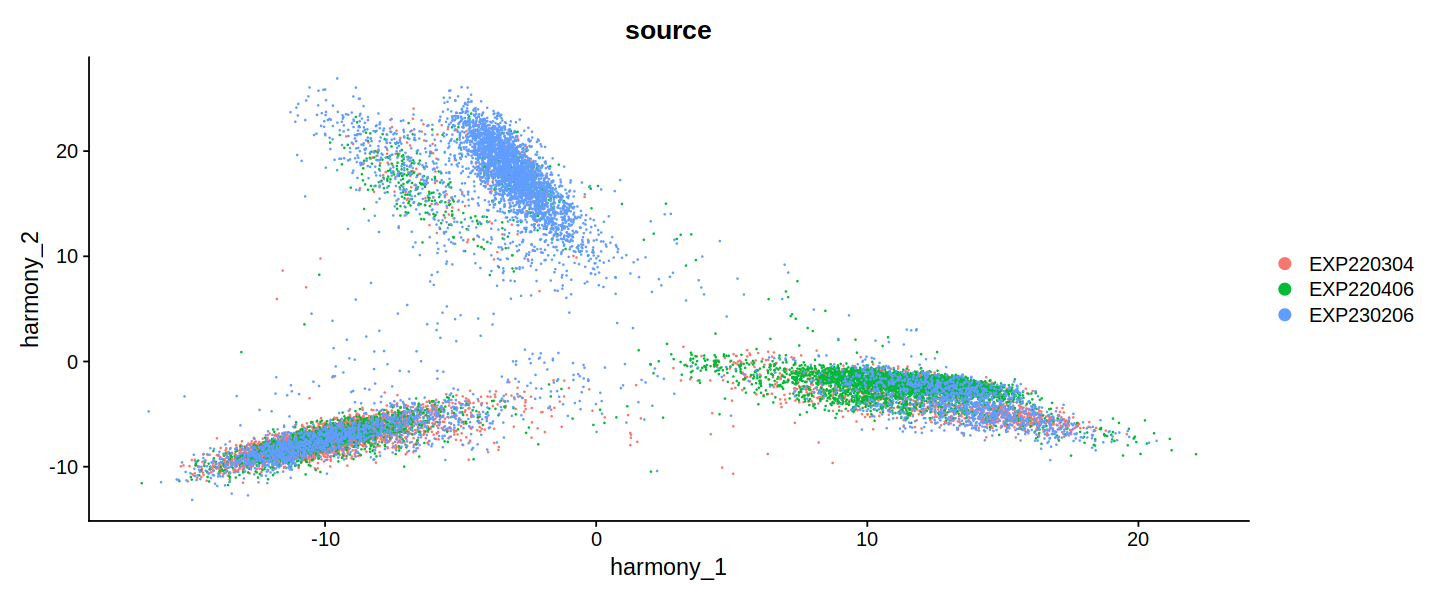

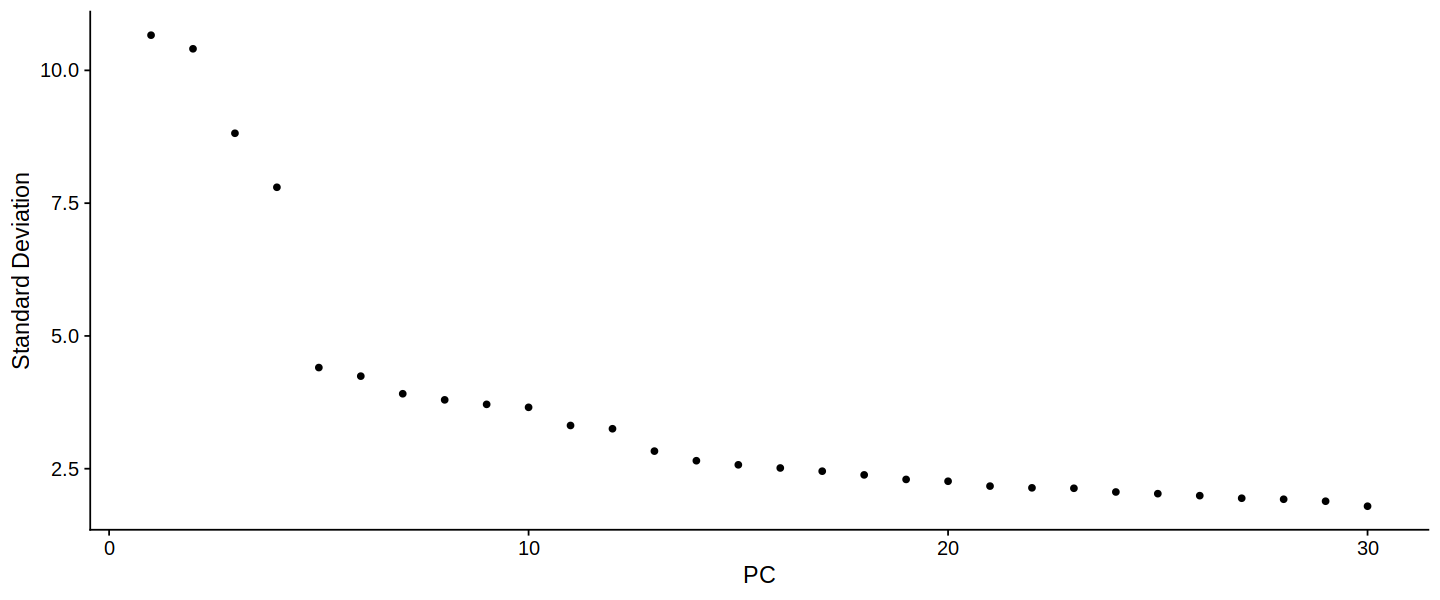

In [12]:
# remove low quality clusters
subsample <- subset(sample, idents = c(11, 12, 13, 16, 17, 19, 22, 23, 25), invert = T)
subsample <- NormalizeData(subsample, normalization.method = "LogNormalize", scale.factor = 10000)
dim(GetAssayData(subsample, slot = "counts"))

# find variable genes and scale data by number of UMIs and mitochondrial gene percentage
subsample <- FindVariableFeatures(subsample, selection.method = "vst")
length(subsample@assays$RNA@var.features)
subsample <- ScaleData(subsample)

# run pca and harmony
subsample <- RunPCA(subsample, verbose = FALSE)
subsample <- RunHarmony(subsample, group.by.vars = "source", verbose = FALSE)
DimPlot(subsample, reduction = "harmony", pt.size = 0.1, group.by = "source")
ElbowPlot(subsample, ndims = 30)

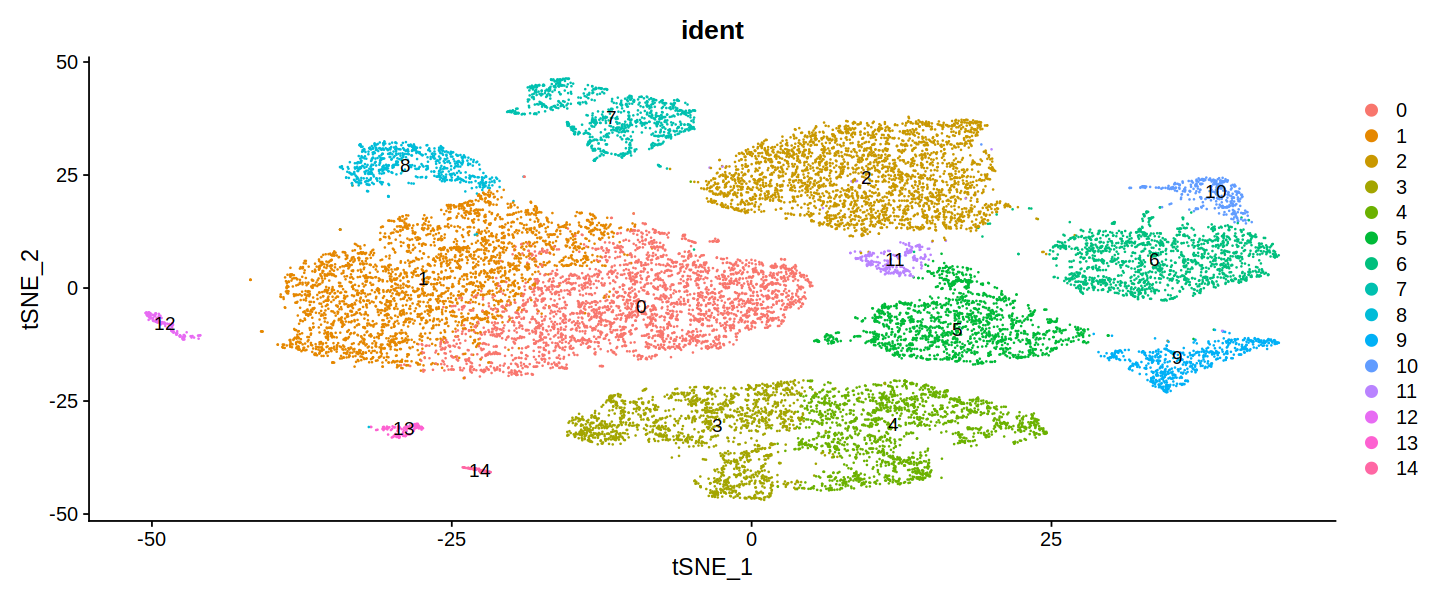

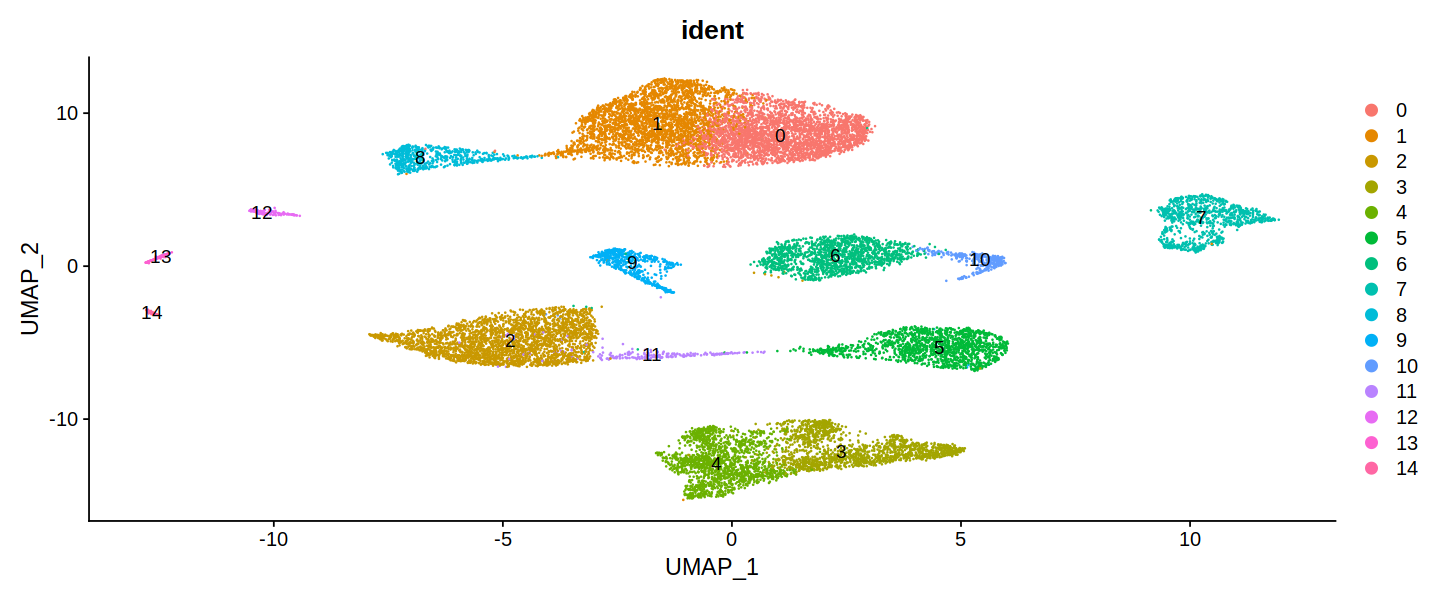

In [13]:
# dimension reduction and clustering
pca_dims <- 1:30
subsample <- RunTSNE(subsample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
subsample <- RunUMAP(subsample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
subsample <- FindNeighbors(subsample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
subsample <- FindClusters(subsample, resolution = 0.5, verbose = FALSE)
DimPlot(subsample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
DimPlot(subsample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

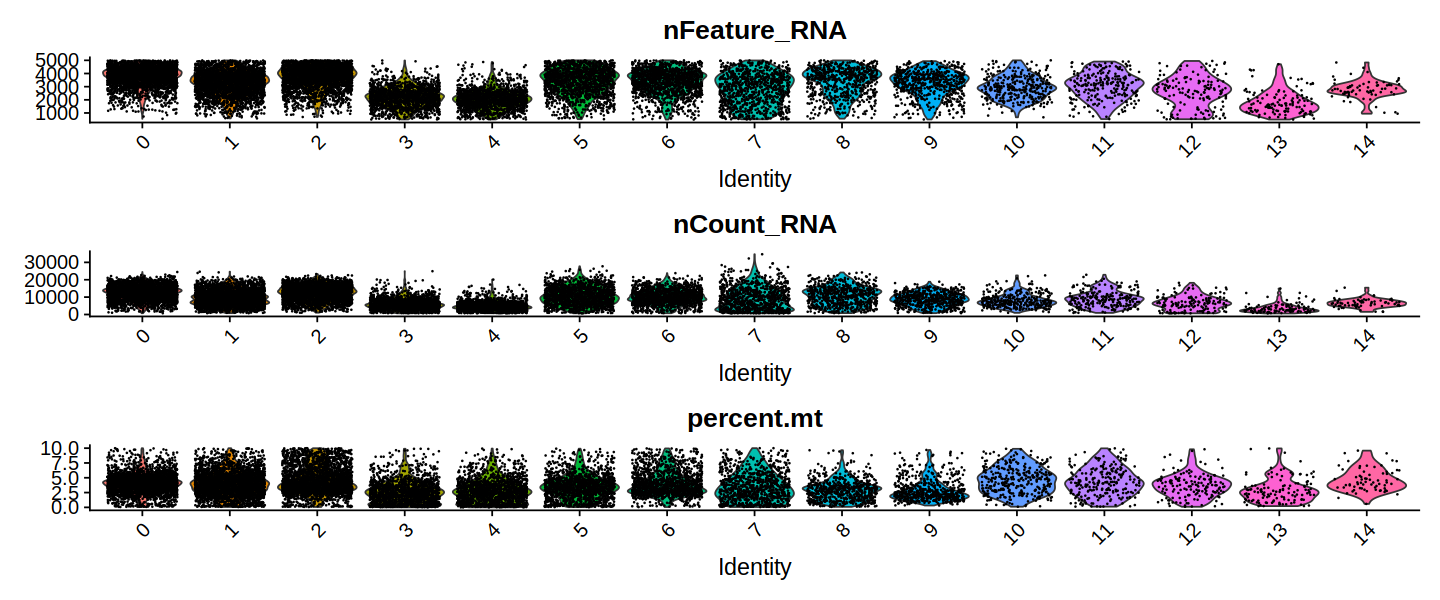

In [14]:
# quality control by cluster
VlnPlot(subsample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 1, pt.size = 0.1)
ggsave("figure/qc_subsample_by_cluster_CAD.pdf", width = 10, height = 10)

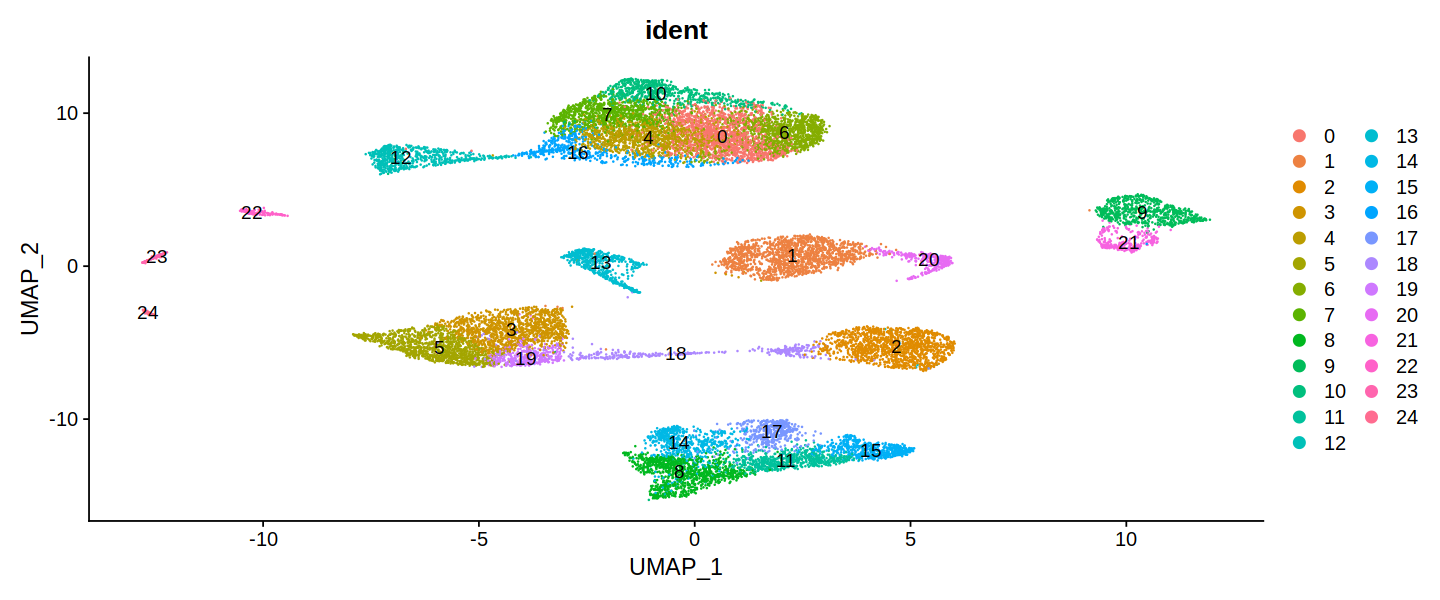

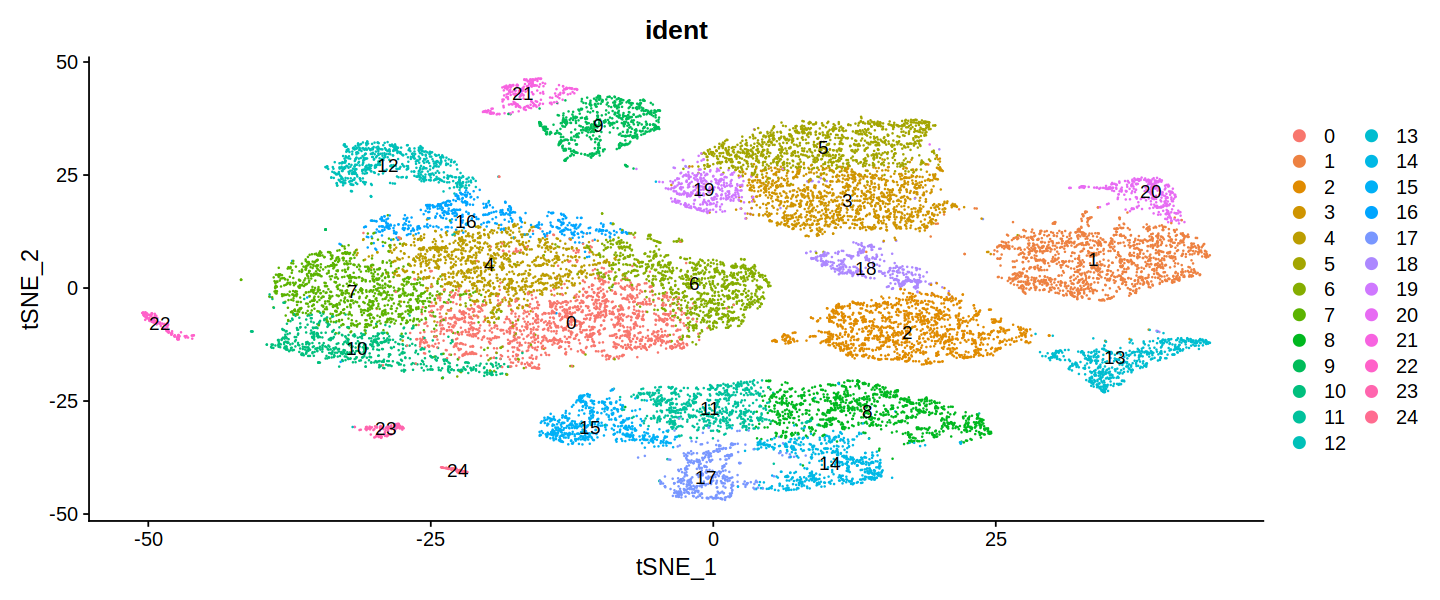

In [15]:
# add resolution
subsample <- FindClusters(subsample, resolution = 1.5, verbose = FALSE)
DimPlot(subsample, label = TRUE, reduction = "umap", group.by = "ident")
DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "ident")

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: HPGD5, TPASB1”


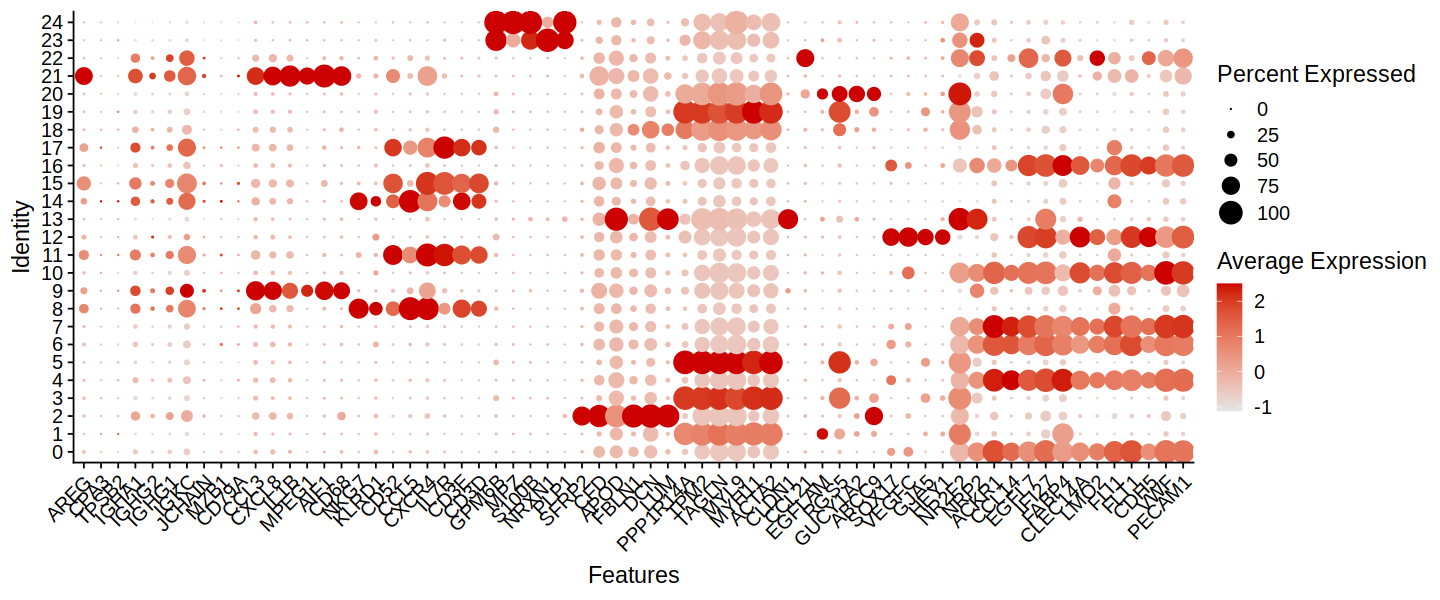

In [16]:
# plot marker genes list
markers <- unique(c("PECAM1","VWF","CDH5","FLT1","FLI1","LMO2","CLEC14A","FABP4","IFI27","EGFL7", # EC
"CCL14","ACKR1","NRP2","NR2F2", # VEC
"HEY1","GJA5","VEGFC","SOX17", # AEC
"ABCC9", "GUCY1A2", "RGS5", "EGFLAM", # Pericyte
"CCL21", # LEC
"CLDN1", # Mesothelial
"ACTA2","MYH11","MYL9","TAGLN","TPM2","RGS5","PPP1R14A", # SMC
"ACTA2","MYH11","LUM","DCN","PPP1R14A", # MyoFB
"LUM","DCN","FBLN1","APOD","CFD","SFRP2", # FB
"PLP1","NRXN1","S100B","MPZ","GPM6B", # OLG
"CD3D","CD3E","IL7R","CXCR4","CCL5","CD52", # T
"KLRD1","NKG7","CCL5", # NK
"CD68","AIF1","MPEG1","IL1B","CXCL8","CCL3","CXCR4", # Macrophage
"CD79A","MZB1","JCHAIN","IGKC","IGHG1","IGHG2","IGHA1", # B
"TPASB1","TPSB2","CPA3","AREG","HPGD5")) # Mast
DotPlot(subsample, features=rev(markers), cols=c("grey90","red3"), group.by="seurat_clusters") + theme(axis.text.x=element_text(angle=45, hjust=1))
ggsave("figure/dotplot_CAD_markers_subsample_CAD.pdf", width = 10, height = 12)

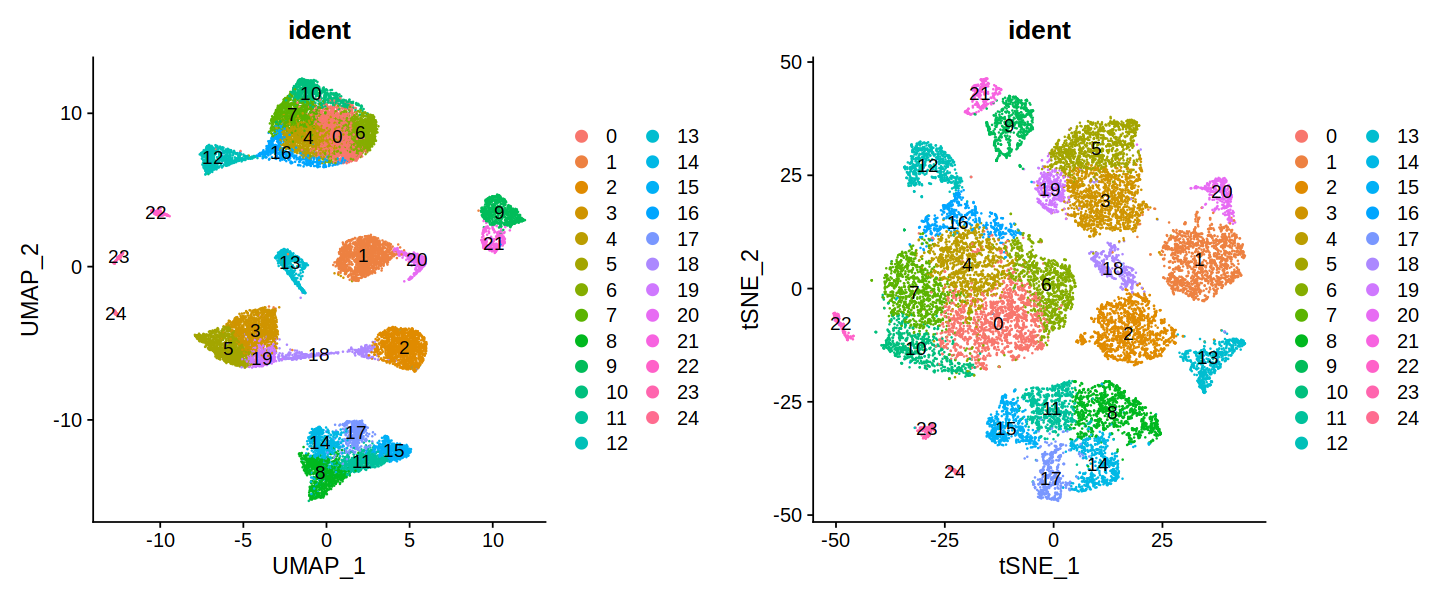

In [17]:
# plot tsne and umap
a <- DimPlot(subsample, label = TRUE, reduction = "umap", group.by = "ident")
b <- DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "ident")
plot_grid(a, b, ncol = 2)

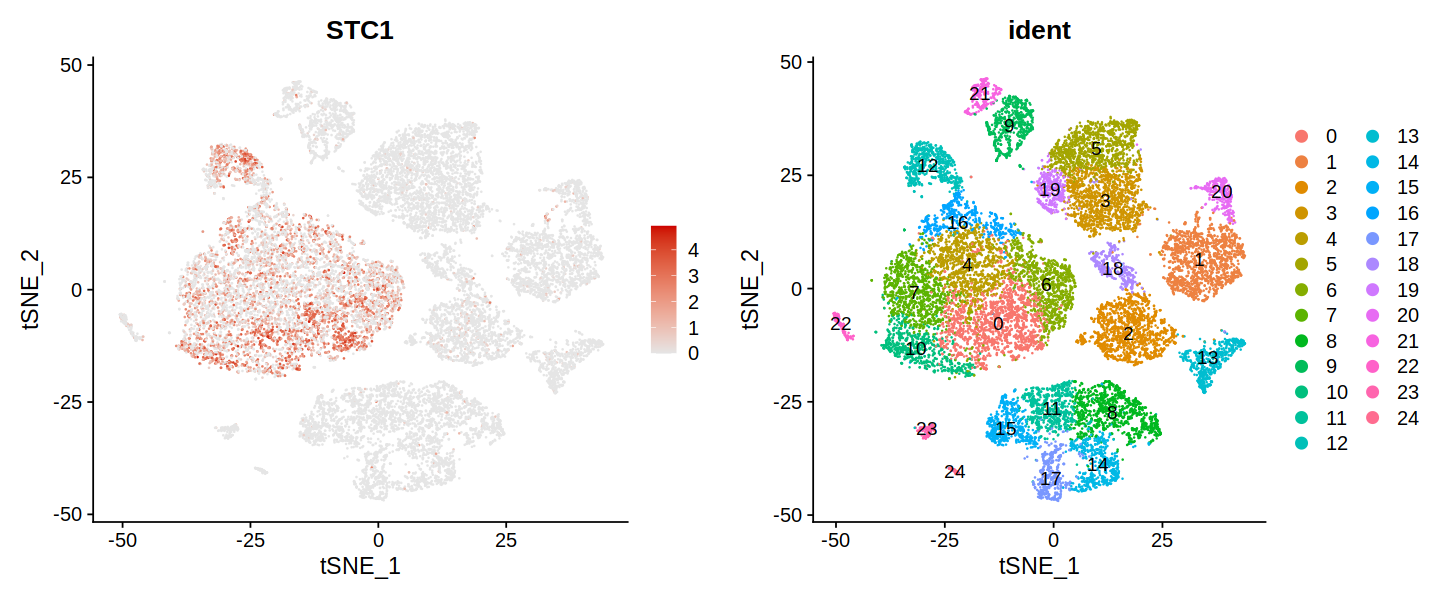

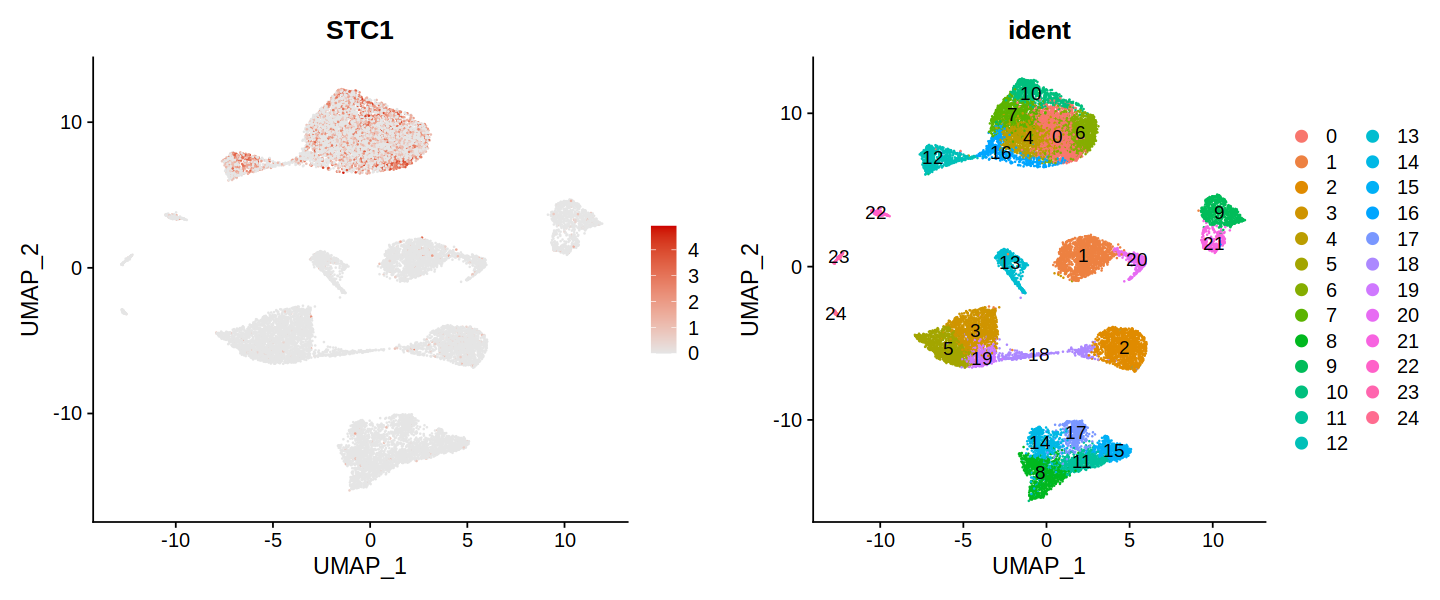

In [18]:
# explore marker genes
gene <- "STC1"
a <- FeaturePlot(subsample, label = F, features=gene, cols=c("grey90","red3"), reduction="tsne", pt.size = 0.1)
b <- DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "ident")
plot_grid(a, b, ncol = 2)

c <- FeaturePlot(subsample, label = F, features=gene, cols=c("grey90","red3"), reduction="umap", pt.size = 0.1)
d <- DimPlot(subsample, label = TRUE, reduction = "umap", group.by = "ident")
plot_grid(c, d, ncol = 2)

In [19]:
# save the subsample
saveRDS(subsample, file = "rds/subsample_CAD.rds")

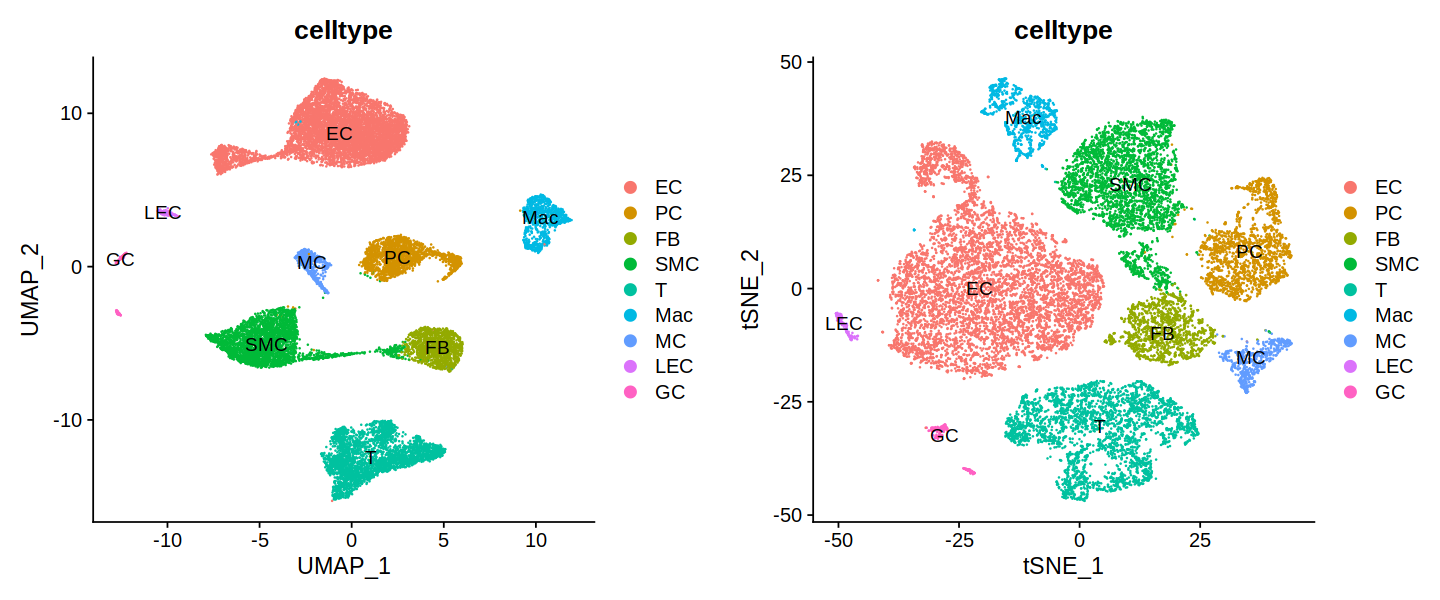

In [20]:
# celltype assignment
cluster = c(0:24)
celltype = c("EC","PC","FB","SMC","EC","SMC","EC","EC","T","Mac",
            "EC","T","EC","MC","T","T","EC","T","SMC","SMC","PC",
            "Mac","LEC","GC","GC")
subsample$celltype = plyr::mapvalues(x=Idents(subsample), from=cluster, to=celltype)
a <- DimPlot(subsample, label = TRUE, reduction = "umap", group.by = "celltype")
b <- DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "celltype")
plot_grid(a, b, ncol = 2)

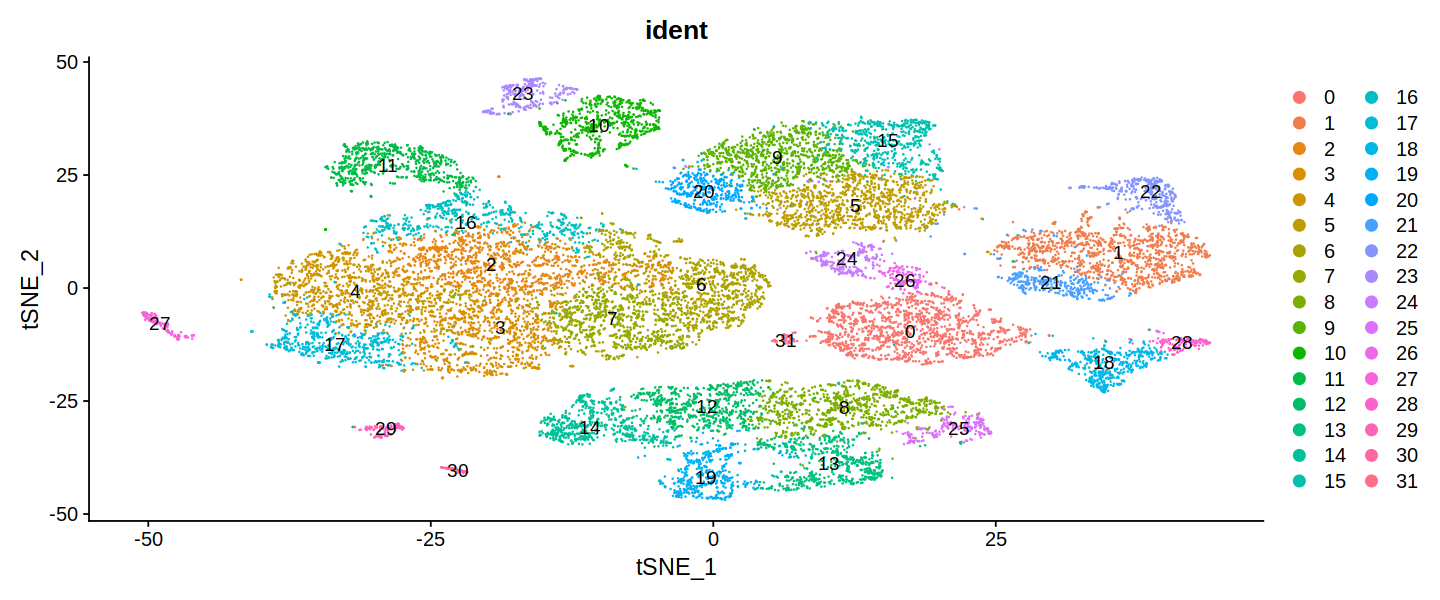

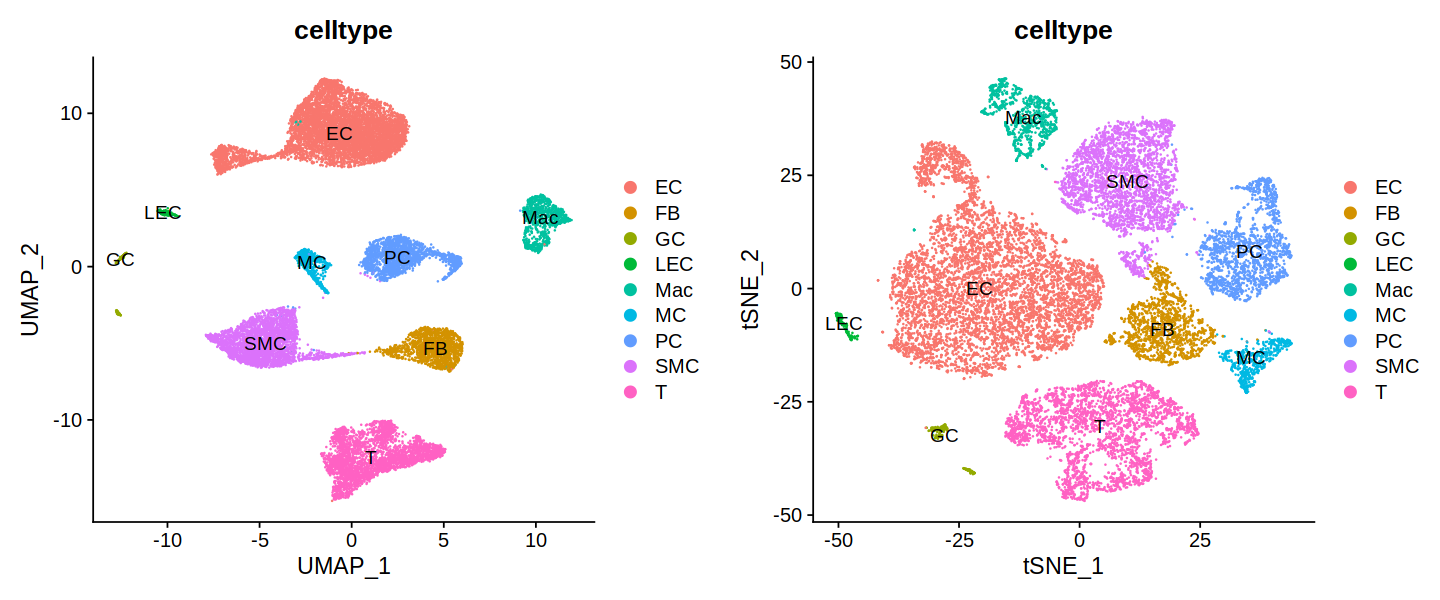

In [21]:
# refine the NKT and FB-MyoFB cell
subsample <- FindClusters(subsample, resolution = 2.5, verbose = FALSE)
DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "ident")
subsample$celltype <- as.character(subsample$celltype)
# subsample@meta.data[colnames(subset(subsample, idents = c(25))), "celltype"] <- "NKT"
subsample@meta.data[colnames(subset(subsample, idents = c(26))), "celltype"] <- "FB"
a <- DimPlot(subsample, label = TRUE, reduction = "umap", group.by = "celltype")
b <- DimPlot(subsample, label = TRUE, reduction = "tsne", group.by = "celltype")
plot_grid(a, b, ncol = 2)
subsample <- FindClusters(subsample, resolution = 1.5, verbose = FALSE)

In [22]:
# save the annotated subsample
saveRDS(subsample, file = "rds/subsample_CAD_annotated_level1.rds")

In [23]:
# calculate markers
markers_cluster <- FindAllMarkers(subsample, only.pos = T, verbose = F)
write.csv(markers_cluster, "meta/markers_CAD_by_cluster.csv")

In [24]:
# calculate celltype markers
subsample$celltype <- factor(subsample$celltype, levels = c("VEC","CEC","AEC","LEC","MC","FB","SMC","PC1","PC2","Mac","T","NKT","GC1","GC2"))
Idents(subsample) <- subsample$celltype
markers_celltype <- FindAllMarkers(subsample, only.pos = T, verbose = F)
write.csv(markers_celltype, "meta/markers_CAD_by_celltype.csv")

In [25]:
# list the session info
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/zju/ty/miniconda/envs/singlecell/lib/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1      ggrepel_0.9.4      RColorBrewer_1.1-3 viridis_0.6.4     
 [5] viridisLite_0.4.2  ggsci_3.0.0        Hmisc_5.1-1        Matrix_1.6-1.1    
 [9] dplyr_1.1.4        sctransform_0.4.0  ggplot2_3.5.1     